In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr

plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)b

ATTENTION: possible bug introduced through wrong application of np.append method

In [2]:
data = simplesim.Manager( directory="./data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="diag", filetype="nc")
plot = simplesim.Manager( executable ="./feltorplot.sh", directory="plot", filetype = "nc")

In [3]:
content = data.table()
print( f"The database contains {np.size(content)} simulations")
for file in content:
    
    print( data.outfile( file), " split into ", data.count( file), " file(s)")

The database contains 3 simulations
./data/07bb8c63064fff3844e807b59765c472390f380a.nc  split into  1  file(s)
./data/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc  split into  4  file(s)
./data/d4a4d6923d9f776d18ea26780e278dbf6c3fb6fb.nc  split into  1  file(s)


In [4]:
config = fp.load_default_config()

with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [5]:
for file in content : 
    for i in range( 0, data.count(file)) :
        print( "Diag ", data.outfile( file), i)
        diag.create(file,i)
        print( "Plot ", data.outfile( file), i)
        plot.create(file,i)

Diag  ./data/07bb8c63064fff3844e807b59765c472390f380a.nc 0
Plot  ./data/07bb8c63064fff3844e807b59765c472390f380a.nc 0
Diag  ./data/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc 0
Plot  ./data/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc 0
Diag  ./data/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc 1
Plot  ./data/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc 1
Diag  ./data/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc 2
Plot  ./data/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc 2
Diag  ./data/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc 3
Plot  ./data/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc 3
Diag  ./data/d4a4d6923d9f776d18ea26780e278dbf6c3fb6fb.nc 0
Plot  ./data/d4a4d6923d9f776d18ea26780e278dbf6c3fb6fb.nc 0


In [13]:
def create_merged_dataset( manager, file ) :
    datasetpaths = []
    for i in range( 0, manager.count( file)) :
        datasetpaths.append( manager.outfile( file, i) )
    dataset = xr.open_mfdataset(datasetpaths, concat_dim='time', decode_times=False, join = "outer")
    # dann brauchst du nen filter damit du die doppelten zeitschritte rausfilter kannst
    filter = np.zeros_like(dataset["time"][:], dtype=bool)
    filter[np.unique(dataset["time"][:], return_index=True)[1]] = True
    return (dataset, filter)


data = simplesim.Manager( directory="./data", filetype="nc")
content = data.table()
file = content [1]


dataset, filter = create_merged_dataset( data, content[1])


#dann kannst du zb die zeit und masse als numpy array laden und damit hantieren
# (du kannst auch mit denen als xarray hantieren dafür gibts aber nicht alle numpy array funktionen ,
# dafür ist es wesentlich schneller!)
#time = np.asarray(dataset["time"][filter])
#mass = np.asarray(dataset["mass"][filter])

In [14]:
 # Temporary easy work with only one list element
full_content = data.table()
content = []
content.append( full_content[1])

### Mass flux out of separatrix

Invert for given numerical parameters
Average flux is 1.72e-03 pm 5.71e-04
Total average mass loss rate is 8445.3
Total mass gain by sources is 8387.4
particle confinement time = 4.95e+02


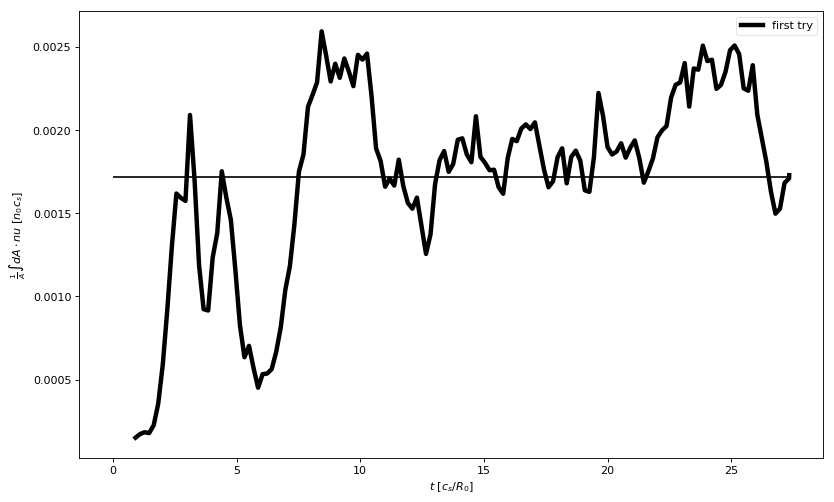

Average flux  [0.0017171]
Sigma flux  [0.00057126]
Confinement time  [0.026988]


In [41]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion
min_idx = 5
confinement_time = np.array([])
average_flux = np.array([])
sigma_flux = np.array([])

fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    #dd = Dataset( data.outfile(file), 'r')
    #da = Dataset( diag.outfile(file), "r")
    da, filter = create_merged_dataset( diag, file)
    da0 = Dataset( diag.outfile( file, 0), 'r')
    #pl = nc.Dataset( plot.outfile(file), "r")
    
    #print( dset)
    pp = json.loads( da.inputfile )
    time = np.asarray(da['time'][filter])
    #print( time)
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    rho = da0['rho'][:]
    rho_t = da0['rho_t'][:]
    rho_p = da0['rho_p'][:]
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    idx = lcfs
    area = da0['psi_area'][:]
    volume = da0['psi_vol'][:]
    
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0'] # R_0 / c_s
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][filter])
    average_mass = np.mean(mass)
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    # jvne= dset.variables['jvneE_tt_fsa'][:,:]
    jvne=np.asarray(da['jvneC_tt_ifs_lcfs'][filter])/deltat
    jvne+=np.asarray(da['jvneE_tt_ifs_lcfs'][filter])/deltat
    jvne+=np.asarray(da['jvneA_tt_ifs_lcfs'][filter])/deltat
    divjvne = np.asarray(da["divjnepar_tt_ifs_lcfs"][filter])/deltat
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    source = np.asarray(da["sne_tt_ifs_lcfs"][filter])/deltat
    average_source = source[min_idx:].mean()

    print( f"Average flux is { average_jvne/area[idx]:1.2e} pm {sigma_jvne/area[idx]:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    average_flux = np.append( average_jvne/area[idx], average_flux )
    sigma_flux = np.append( sigma_jvne/area[idx], sigma_flux )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    confinement_time = np.append( average_mass/average_jvne*1e-7, confinement_time )
    tau = mass/jvne

    plt.plot(time[min_idx:]*timescale,jvne[min_idx:]/area[idx], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, label='first try')
    plt.hlines(average_jvne/area[idx], time[0]*timescale, time[len(time)-1]*timescale, color='k')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
plt.xlabel(r"$t\ [c_s/R_0]$")
plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")

plt.show(   )
print( "Average flux ", average_flux)
print( "Sigma flux ", sigma_flux)
print( "Confinement time ", confinement_time)

### Volume Integrated Mass conservation

Average diff =  132.89169969379682


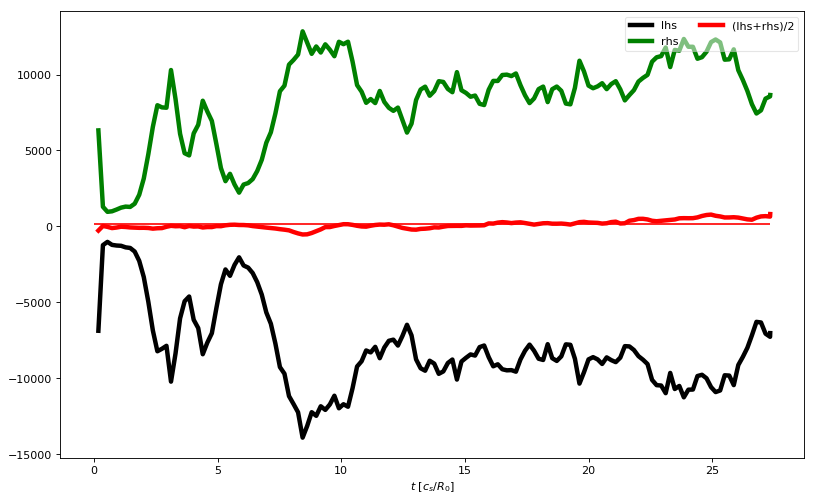

In [36]:
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    #dset = Dataset( diag.outfile(file), 'r')
    dset, filter = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][filter])
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    
    mass = np.asarray(dset.variables['electrons_ifs_lcfs'][filter])
    masstt=np.append(np.zeros(1),mass, axis=0)

    deltamass = np.diff(masstt,axis=0)/deltat
    source = np.asarray(dset.variables['sne_tt_ifs_lcfs'][filter])/deltat
    deltamass-=source
    jvne= np.asarray(dset['jvneE_tt_ifs_lcfs'][filter])/deltat
    jvne+=np.asarray(dset['jvneC_tt_ifs_lcfs'][filter])/deltat
    jvne+=np.asarray(dset['jvneA_tt_ifs_lcfs'][filter])/deltat
    divjvnepar=np.asarray(dset['divjnepar_tt_ifs_lcfs'][filter])/deltat
    #jvne+=divjvnepar

    diff_perp = np.asarray(dset["lneperp_tt_ifs_lcfs"][filter])/deltat
    rhs = jvne-diff_perp
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean(diff[1:])
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,deltamass[1:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="rhs")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
#     plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
#              ls='--', lw = 4, label="parallel")

1
    dset.close()
    
plt.xlabel(r"$t\ [c_s/R_0]$")

plt.show(   )

### Average FSA Mass conservation 

Average diff =  5.624493778532255e-07
Average std  =  2.9444861018349596e-06


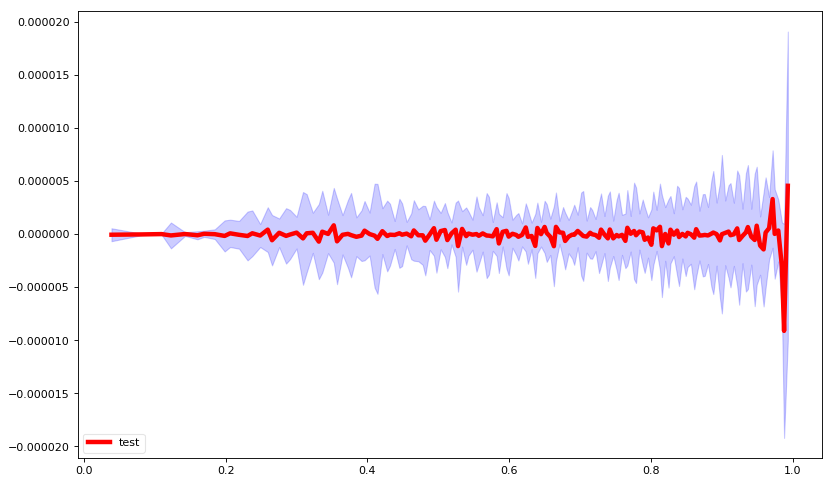

In [37]:
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    #dset = Dataset( diag.outfile(file), 'r')
    
    dset, filter = create_merged_dataset( diag, file)
    mass =np.asarray(dset.variables['electrons_fsa'][filter,:])
    time = np.asarray(dset.variables['time'][filter])
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(dset.variables['sne_tt_fsa'][filter,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(dset.variables['jvneC_tt_ifs'][filter,:])/deltat[:,None]
    jvneE=np.asarray(dset.variables['jvneE_tt_ifs'][filter,:])/deltat[:,None]
    jvneA=np.asarray(dset.variables['jvneA_tt_ifs'][filter,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(dset.variables["lneperp_tt_fsa"][filter,:])/deltat[:,None]
    rhs = jvne-diff_perp
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])

    plt.plot( rho_t[0:167], average_diff[0:167], ls = '-', color='r', lw = 4, label = 'test')
    plt.fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='b', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()

### Local Mass conservation on LCFS

Average diff =  0.0003065349109300034
Average std  =  0.0016047449255000414


Text(0.5,0,'$t\\ [c_s/R_0]$')

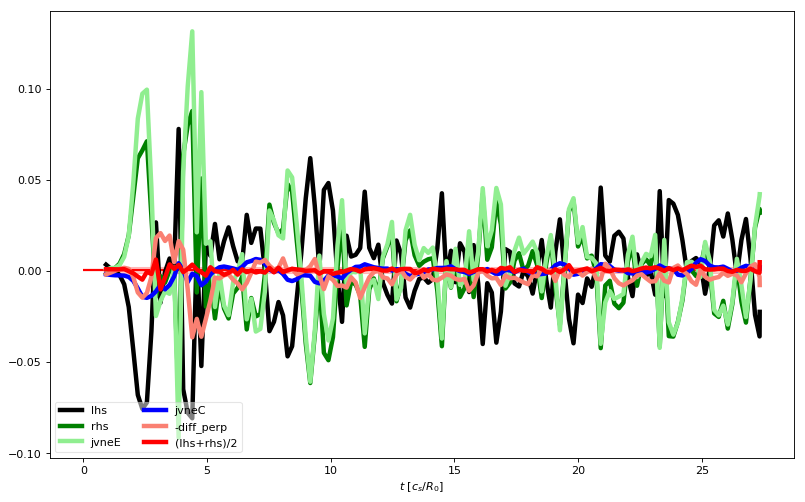

In [40]:
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    dset, filter = create_merged_dataset( diag, file)
    mass =np.asarray(dset.variables['electrons_fsa'][filter,:])
    time = np.asarray(dset.variables['time'][filter])*timescale
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(dset.variables['sne_tt_fsa'][filter,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(dset.variables['jvneC_tt_ifs'][filter,:])/deltat[:,None]
    jvneE=np.asarray(dset.variables['jvneE_tt_ifs'][filter,:])/deltat[:,None]
    jvneA=np.asarray(dset.variables['jvneA_tt_ifs'][filter,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(dset.variables["lneperp_tt_fsa"][filter,:])/deltat[:,None]
    rhs = jvne-diff_perp
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot(time[min_idx:],deltamass[min_idx:,idx], color='k', marker='',
              ls='-',lw=4, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g',
              ls='-', lw = 4,  label="rhs")
    plt.plot(time[min_idx:],jvneE[min_idx:,idx], color='lightgreen',
              ls='-', lw = 4, label="jvneE")
    plt.plot(time[min_idx:],jvneC[min_idx:,idx], color='blue',
              ls='-', lw = 4, label="jvneC")
    plt.plot(time[min_idx:],-diff_perp[min_idx:,idx], color='salmon',
              ls='-', lw = 4,  label="-diff_perp")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r',
              ls='-', lw = 4,  label="(lhs+rhs)/2")
    plt.hlines(average_diff[idx], time[0], time[len(time)-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
plt.xlabel(r"$t\ [c_s/R_0]$")

### Density profile

Dataset length  151
Average region  <xarray.Variable ()>
array(0.91743119) <xarray.Variable ()>
array(27.34495141)


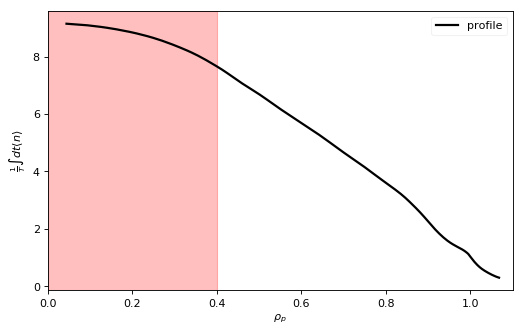

In [42]:

fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :


    dset, filter = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )

    time = dset.variables['time'][filter]

    density =dset.variables['electrons_fsa'][filter]
    source = dset.variables['sne_tt_fsa'][filter]
    print( "Dataset length ", len(time))
    print( "Average region ", time[min_idx]*timescale, time[len(time)-1]*timescale)
    avg_density=density[min_idx:len(time)-1].mean(axis=0)
    avg_source = source.mean(axis=0)
    plt.plot( rho_p, avg_density, color='k', ls='-', lw=2, label='profile' )
    # plt.plot( rho_t, density[len(time)-1,:],color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( rho_t, avg_source*1000,color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( rho_t,   -psi_p*3+1, ls='--', color = 'k')
#     plt.plot( rho_p,   -psi_p/2+1, ls='--', color = 'k')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.25)
    dset.close()
ax.axvspan(0, 0.4, alpha=0.25, color='red')

plt.xlabel(r"$\rho_p$")
# plt.xlabel(r"$\sqrt{\psi_p/\psi_{O}}$")

plt.ylabel(r"$\frac{1}{T}\int dt \langle n\rangle$")
plt.xlim(0,1.1)
# plt.ylim(0,27)
# plt.ylim(0,30000)
plt.show(  )

### Vorticity accuracy on LCFS

Index 167 vs lcfs 167
167
0.9982504105290855
Average diff =  1.4312917637477332e-06
Average std  =  3.008342655700158e-06


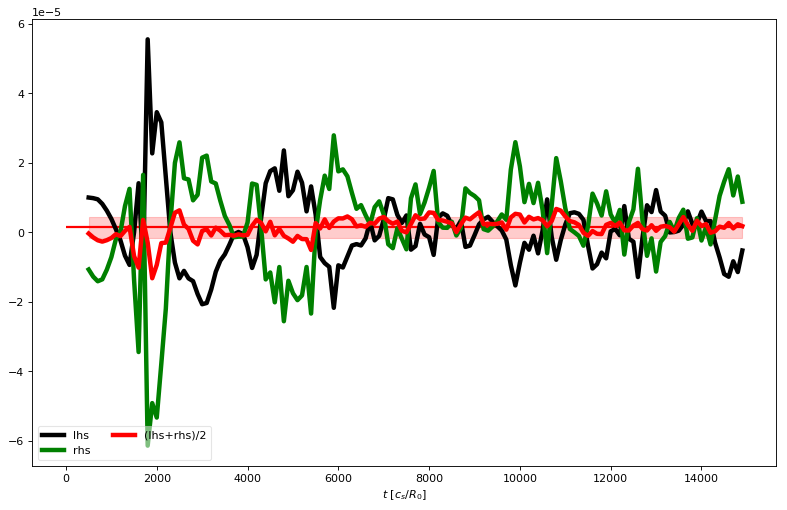

In [51]:
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    dset, filter = create_merged_dataset( diag, file)
    filter[len(filter)-1] = False
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][filter])
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    
#     vorticity = dset['vorticity_fsa'][filter,:]
#     el = dset['electrons_ifs'][filter,:]
#     ions = dset['ions_ifs'][filter,:]
#     dvdpsip=dset['dvdpsi'][:]
#     vorticity = (el-ions)/dvdpsip
    vorticity =np.asarray(dset['oexbe_fsa'][filter,:])
    # vorticity+=dset['odiae_fsa'][filter,:]
    # vorticity/=dset['electrons_fsa'][filter,:]
    tttvorticity=np.append(np.zeros((1,len(rho_t))),vorticity, axis=0)
    deltavorticity = np.diff(tttvorticity,axis=0)/deltat[:,None]
    jvoE= np.asarray(dset['jvoexbe_tt_ifs'][filter,:])/deltat[:,None]
    jvoD= np.asarray(dset['jvoexbeUD_tt_ifs'][filter,:])/deltat[:,None]
    # jvoD= dset.variables['jvodiaeUE_tt_ifs'][filter,:]/deltat[:,None]
    maxwell= np.asarray(dset['jvoapar_tt_ifs'][filter,:])/deltat[:,None]
    jvoA= np.asarray(dset['jvoexbApar_tt_ifs'][filter,:])/deltat[:,None]
    # jvoA= dset['jvodiaApar_tt_ifs'][filter,:]/deltat[:,None]
    jvo = jvoE + jvoD + maxwell + jvoA
    force = -np.asarray(dset["socurve_tt_fsa"][filter,:])/deltat[:,None]
    force -= np.asarray(dset["socurvi_tt_fsa"][filter,:])/deltat[:,None]
    force -= np.asarray(dset["socurvkappae_tt_fsa"][filter,:])/deltat[:,None]
    force -= np.asarray(dset["socurvkappai_tt_fsa"][filter,:])/deltat[:,None]
    # force2 = -dset["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
    # source = dset["sosne_tt_fsa"][:,:]/deltat[:,None]
    # source+= dset["sospi_tt_fsa"][:,:]/deltat[:,None]
    lamb = np.asarray(dset["loexbe_tt_fsa"][filter,:])/deltat[:,None]
    #lamb = dset['lneperp_tt_ifs'][:,:]/deltat[:,None]

    #lamb = lamb/dvdpsip[None,:]

    rhs = jvo+force-lamb#-source
    # diff = +deltavorticity + rhs
    diff = (deltavorticity +rhs)/2
    # delayed_diff = (deltavorticity[0:-1,:]+rhs[1:,:])/2
    average_diff = np.mean( diff[1:], axis=0)
    average_std = np.std( diff[1:], axis=0)
    # rhs = rhs - 2*average_diff[None, :]
    # diff = ( deltavorticity + rhs)/2
    
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    print( "Index 167 vs lcfs", lcfs)
    idx= 167
    print( idx)
    print( rho_t[idx])
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot(time[min_idx:],deltavorticity[min_idx:,idx], color='k', marker='',
              ls='-',lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g', marker='',
              ls='-', lw = 4, markeredgecolor='k', markersize=8, label="rhs")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r', marker='',
              ls='-', lw = 4, markeredgecolor='k', markersize=8, label="(lhs+rhs)/2")
#     plt.plot(time[min_idx:],10*jvoE[min_idx:,idx], color='salmon', marker='',
#               ls='-',lw=4,markeredgecolor='k', markersize=8, label="jvoE")
#     plt.plot(time[min_idx:],10*jvoD[min_idx:,idx], color='lightblue', marker='',
#               ls='-',lw=4,markeredgecolor='k', markersize=8, label="jvoD")
#     # plt.plot(time[min_idx:],-source[min_idx:,idx], color='crimson', marker='',
#     #           ls='-', lw = 4, markeredgecolor='k', markersize=8, label="-source")
#     plt.plot(time[min_idx:],force[min_idx:,idx], color='y', marker='',
#               ls='-', lw = 4, markeredgecolor='k', markersize=8, label="force")
#     plt.plot(time[min_idx:],jvoA[min_idx:,idx], color='orange', marker='',
#               ls='-', lw = 4, markeredgecolor='k', markersize=8, label="jvoA")
#     plt.plot(time[min_idx:],maxwell[min_idx:,idx], color='pink', marker='',
#               ls='-', lw = 4, markeredgecolor='k', markersize=8, label="Maxwell")
    # plt.plot(time[min_idx:],-lamb[min_idx:,idx], color='lightyellow', marker='',
    #           ls='-', lw = 4, markeredgecolor='k', markersize=8, label="-lambda")
    plt.hlines(average_diff[idx], time[0], time[len(time)-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    # print(time[len(time)-1])
    # idx = np.where( time[np.where( time < 9356)]>9354)
    # print( idx[0][0] )
    # plt.plot( rho_t, force[ idx[0][0],: ], color='y', label = "force")
    # plt.plot( rho_t, jvo[ idx[0][0],: ], color='r', label = "jvo")
    # plt.plot( rho_t, deltavorticity[ idx[0][0],: ], color='g', label = "dO")
    
    
    # plt.plot( rho_t, average_diff, ls = '-', color=v[0], lw = 4, label = v[1])
    # plt.fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
    #                   average_diff[0:167]+average_std[0:167], color=v[0], alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
plt.xlabel(r"$t\ [c_s/R_0]$")
# plt.xlabel(r"$\rho_t$")
# plt.xlim(0,6)
# plt.ylabel(r"$\int dV \Omega_E$")
#plt.xlim(6360,6400)
# plt.xlim(0,1.0)
# plt.ylim(-2e-2,2e-2)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show(   )